## 2 layer model, 250 products

## We compare with EXP7

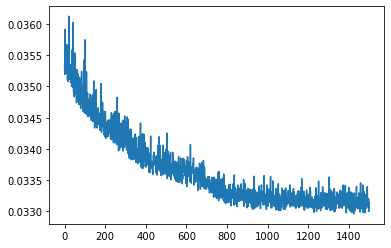

In [14]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

vali_loss = np.load('EXP7_dump/bottleneck_vali_loss_LARGE.npy')
plt.plot(vali_loss[500:])

In [10]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        
Vec_Len = N_prod + 1
# Tune this
MidSize = 200

EPOCHS = 1000
SAMPLE_AMOUNT = 100000
BATCH_SIZE = 5000
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.005

# generate latent parameters
transP = np.load("EXP7_dump/markov_matrix.npy")
lams = np.load("EXP7_dump/arriving_lambda.npy")

model = Models.DNN2layer(Vec_Len, MidSize)

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    
    # generate input vector, which has length vec_len
    # the first element is 0, which should be ignored when treated as an assortment
    assort = AG.GenAssortment_Abundant(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = np.array([])
vali_losses = np.array([])

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
        print(time.time()-start_time)
    
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_pure = loss.detach().item()
        loss_base = criterion(TEST,TEST).detach().item()
        training_losses= np.append(training_losses,(loss_pure - loss_base)/loss_base)
        
    for step, (VALI_IN, VALI_TEST) in enumerate(vali_loader):
        VALI_OUT = model(VALI_IN)
        
        RELATIVE_LOSS = nn.functional.l1_loss(VALI_TEST, VALI_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(VALI_TEST, min = 1/Vec_Len)

        losses = np.mean(torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=4).detach().numpy())
        
        vali_losses = np.append(vali_losses,losses)

np.save('EXP13_dump/markov_matrix',transP)
np.save('EXP13_dump/arriving_lambda',lams)
np.save('EXP13_dump/DNN2_train_loss', training_losses)
np.save('EXP13_dump/DNN2_vali_loss', vali_losses)
torch.save(model, "EXP13_dump/DNN2_model.pth")

data generated!
total time elapse :  77.3733024597168


D:\CODING\Assortment_NN\AssortmentNN\Models.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)
D:\SOFTWARE\ANACONDA\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


epoch :  50
166.76341843605042
epoch :  100
258.9099566936493
epoch :  150
352.7075352668762
epoch :  200
446.2133584022522
epoch :  250
538.9588928222656
epoch :  300
632.1871972084045
epoch :  350
725.4334876537323
epoch :  400
818.7916135787964
epoch :  450
911.4187917709351
epoch :  500
1004.5990588665009
epoch :  550
1098.3955001831055
epoch :  600
1191.754285812378
epoch :  650
1285.0291411876678
epoch :  700
1378.5166466236115
epoch :  750
1472.8312752246857
epoch :  800
1566.6231317520142
epoch :  850
1661.433756351471
epoch :  900
1756.463559627533
epoch :  950
1853.3253252506256
epoch :  1000
1947.7707970142365


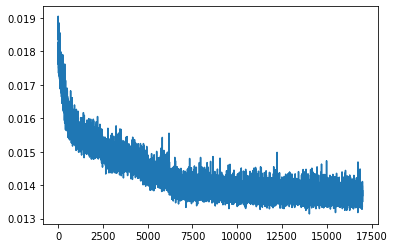

In [11]:
train_loss = np.load('EXP13_dump/DNN2_train_loss.npy')
plt.plot(train_loss[1000:])

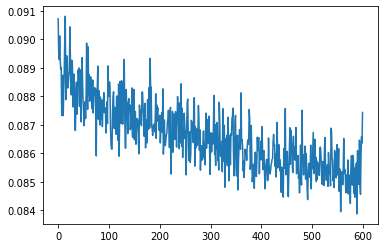

In [13]:
import numpy as np
import matplotlib.pyplot as plt

vali_loss = np.load('EXP13_dump/DNN2_vali_loss.npy')
plt.plot(vali_loss[400:])

## test

D:\SOFTWARE\ANACONDA\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(array([373716.,   3699.,   3708.,   3860.,   3958.,   4248.,   4419.,
          4634.,   4817.,  94941.]),
 array([5.0294936e-08, 2.5000045e-02, 5.0000042e-02, 7.5000033e-02,
        1.0000003e-01, 1.2500003e-01, 1.5000002e-01, 1.7500001e-01,
        2.0000000e-01, 2.2500001e-01, 2.5000000e-01], dtype=float32),
 <BarContainer object of 10 artists>)

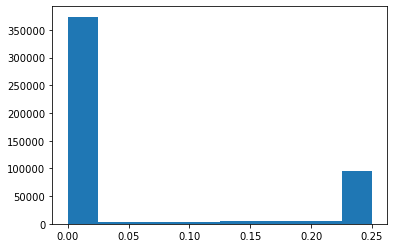

In [3]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

transP = np.load("EXP7_dump/markov_matrix.npy")
lams = np.load("EXP7_dump/arriving_lambda.npy")

N_prod = 250        # number of products
Vec_Len = N_prod + 1

DENSE_AMOUNT = 2000

model = torch.load("EXP7_dump/bottleneck_model_LARGE.pth")
INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Even(N_prod, 26/100)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=0.25).detach().numpy()

plt.hist(losses)